In [260]:
import torch
import torch.nn as nn
import torch.optim as optim

data_len = 65400
bits = 16
def binary_sequence_tensor(num_bits, length):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    #binary_tensor[binary_tensor == 0] = -1
    return binary_tensor


def binary_sequence_tensor_with_single_offset(num_bits, length):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    #binary_tensor[binary_tensor == 0] = -1
    for i in range(num_bits -1):
        print(i+1, 2**(i))
        add = torch.roll(binary_tensor[:,i+1], shifts=2**(i), dims=0).unsqueeze(-1)
        binary_tensor = torch.cat((binary_tensor,add), dim = 1)
    
    return binary_tensor

def binary_sequence_tensor_with_offsets(num_bits, length, offsets = 10):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    res = binary_tensor
    binary_tensor[binary_tensor == 0] = -1
    for i in range(offsets):
       
        add = torch.roll(binary_tensor, shifts=i+1, dims=0)
        res = torch.cat((res,add), dim = 1)
    
    return res


# Example: 10 bits and a length of 100
binary_tensor = binary_sequence_tensor_with_offsets(bits, data_len, 5)
bits = binary_tensor.shape[-1]
print(binary_tensor.shape, bits)  # Should print torch.Size([100, 10])


torch.Size([65400, 96]) 96


In [261]:
binary_tensor

tensor([[ 1., -1., -1.,  ...,  1.,  1.,  1.],
        [-1.,  1., -1.,  ...,  1.,  1.,  1.],
        [ 1.,  1., -1.,  ...,  1.,  1.,  1.],
        ...,
        [-1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1., -1., -1.,  ...,  1.,  1.,  1.]])

In [262]:
2**bits

79228162514264337593543950336

In [4]:
def add_gaussian_noise(data, noise_std=0.1, noise_fraction=0.1):
    """
    Adds Gaussian noise to the beginning and end of the data.
    
    Parameters:
        data (numpy.ndarray): The input data to which noise will be added.
        noise_std (float): The standard deviation of the Gaussian noise.
        noise_fraction (float): The fraction of the data at the beginning and end where noise will be added.
    
    Returns:
        numpy.ndarray: Data with added Gaussian noise.
    """
    # Determine the length of the data and the size of the noise sections
    data_len = len(data)
    noise_len = int(data_len * noise_fraction)

    # Generate Gaussian noise for the beginning and end of the data
    noise_start = np.random.normal(0, noise_std, noise_len)
    noise_end = np.random.normal(0, noise_std, noise_len)

    # Create a copy of the data to modify
    noisy_data = data.copy()

    # Add noise to the beginning and end
    noisy_data[:noise_len] = noise_start
    noisy_data[-noise_len:] = noise_end

    return noisy_data


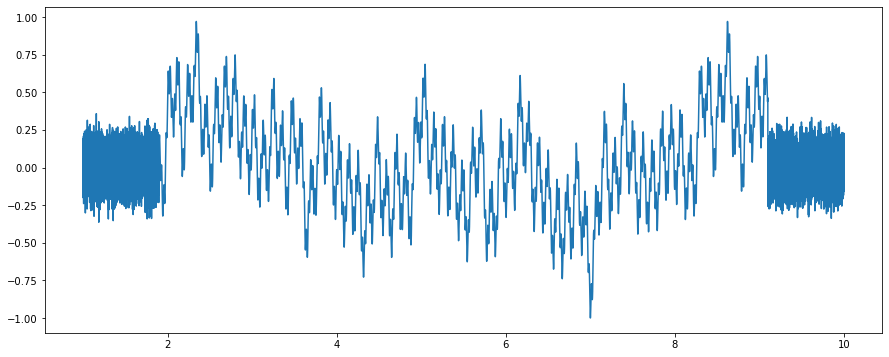

In [6]:
import numpy as np
import matplotlib.pyplot as plt
data_t = torch.from_numpy(np.linspace(1,10,data_len))


data =  (16*torch.sin(2*data_t+3)  
    + 2*torch.sin(6*data_t+1.93)  
    + 12*torch.sin(26*data_t+4.2) 
    + 16*torch.sin(21*data_t+2.43)  
    + 33*torch.sin(56*data_t+1.9)  
    + 11*torch.sin(17*data_t+24) 
    + 7.5*torch.sin(2*data_t+3)  
    + 9.4*torch.sin(6*data_t+1.93)  
    + 15.7*torch.sin(246*data_t+4.2) 
    + 17.5*torch.sin(11*data_t+2.43)  
    + 18*torch.sin(5*data_t+1.9)  
    + 25.8*torch.sin(1*data_t+24) )
data = data.detach().numpy().astype(np.float64)
max_amp = max(abs(data))
data = data/max_amp
data = add_gaussian_noise(data, noise_std=0.1, noise_fraction=0.1)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')

Sample Rate: 24000
Data Shape: (65400,)
20240


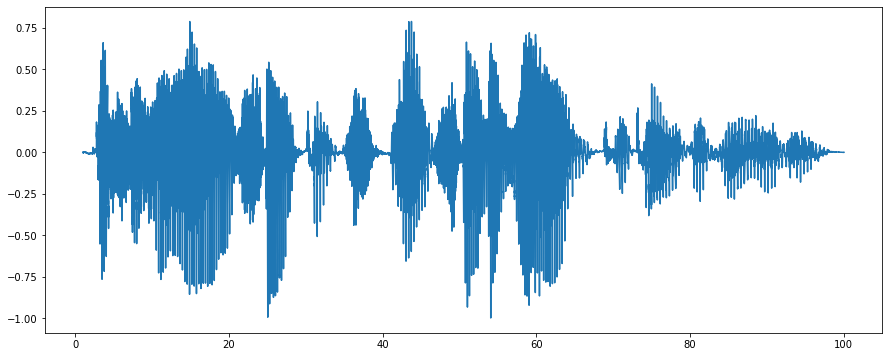

In [124]:
import numpy as np
from scipy.io import wavfile

# Load the WAV file
file_path = 'long_target.wav'
sample_rate, data = wavfile.read(file_path)

# Print out the sample rate and the shape of the numpy array
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
data_t = torch.from_numpy(np.linspace(1,100,data.shape[0]))
max_amp = max(abs(data))
data = data/max_amp
##data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')


print(max_amp)


In [8]:
data.shape

(65400,)

In [281]:
from torch.utils.data import Dataset, Sampler, DataLoader
class WaveformDataset(Dataset):
    def __init__(self, wav_data, t_input):
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data) 

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]
    
class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size


    
    

wav_data = data  # Example waveform data
t_input = binary_tensor  # Example time step data

dataset = WaveformDataset(wav_data, t_input)
batch_size = 200
consecutive_size = 10

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)




In [254]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CustomSinDataset(Dataset):
    def __init__(self, binary_tensor, data):
        self.binary_tensor = binary_tensor
        self.data = data

    def __len__(self):
        return len(self.data)  # Return the number of samples

    def __getitem__(self, idx):
        # For each sample, return the input (binary_tensor) and the corresponding prediction (data)
        return self.binary_tensor[idx], self.data[idx]

# Creating your dataset
def create_dataloader(binary_tensor, data, batch_size=32, shuffle=True):
    # Initialize dataset
    dataset = CustomSinDataset(binary_tensor, data)

    # Wrap the dataset in a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataloader

In [267]:
batch_size = 800  # Define your batch size
dataloader = create_dataloader(binary_tensor, data, batch_size=batch_size)

"""
# Loop through DataLoader
for inputs, targets in dataloader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    print(inputs, targets)
    break
"""

"\n# Loop through DataLoader\nfor inputs, targets in dataloader:\n    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')\n    print(inputs, targets)\n    break\n"

In [202]:
class SimpleModel4(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(SimpleModel4, self).__init__()
        
        # A few fully connected layers with ReLU activation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        self.fc12 = nn.Linear(input_dim, hidden_dim)
        self.relu12 = nn.ReLU()
        self.fc22 = nn.Linear(hidden_dim, hidden_dim)
        self.relu22 = nn.ReLU()
        self.fc32 = nn.Linear(hidden_dim, output_dim)
        
        self.fc13 = nn.Linear(input_dim, hidden_dim)
        self.relu13 = nn.ReLU()
        self.fc23 = nn.Linear(hidden_dim, hidden_dim)
        self.relu23 = nn.ReLU()
        self.fc33 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, t):
        x = self.fc1(t)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x) 
        
        y = self.fc12(t)
        y = self.relu12(y)
        y = self.fc22(y)
        y = self.relu22(y)
        y = self.fc32(y) 
        
        y = y + x
        
        z = self.fc12(t)
        z = self.relu12(z)
        z = self.fc22(z)
        z = self.relu22(z)
        z = self.fc32(z) 
        
        z = z + y
        return z

# Example of creating the model
input_dim = bits  # The input binary tensor has 10 bits per sample
output_dim = 1  # We are predicting a single value per input
hidden_dim = 64  # Number of units in hidden layers (you can adjust this)

model = SimpleModel4(bits, output_dim, hidden_dim)

# Now the `model` is ready to be used in your training loop
print(model)

SimpleModel4(
  (fc1): Linear(in_features=31, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc12): Linear(in_features=31, out_features=64, bias=True)
  (relu12): ReLU()
  (fc22): Linear(in_features=64, out_features=64, bias=True)
  (relu22): ReLU()
  (fc32): Linear(in_features=64, out_features=1, bias=True)
  (fc13): Linear(in_features=31, out_features=64, bias=True)
  (relu13): ReLU()
  (fc23): Linear(in_features=64, out_features=64, bias=True)
  (relu23): ReLU()
  (fc33): Linear(in_features=64, out_features=1, bias=True)
)


In [291]:
import torch
import torch.nn as nn

class SimpleModel5(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_networks=3):
        super(SimpleModel5, self).__init__()
        
        # Store the number of duplicate networks
        self.num_networks = num_networks

        # Dynamically create the duplicate networks and store in a ModuleList
        self.networks = nn.ModuleList()
        for _ in range(num_networks):
            layers = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )
            self.networks.append(layers)
        
    def forward(self, t):
        # First pass through the first network
        output = self.networks[0](t)
        
        # Chain the remaining networks, adding the outputs
        for i in range(1, self.num_networks):
            output = self.networks[i](t) + output
        
        return output

# Example of creating the model
input_dim = bits  # The input binary tensor has 4 bits per sample (in your case)
output_dim = 1    # We are predicting a single value per input
hidden_dim = 64   # Number of units in hidden layers (you can adjust this)
num_networks = 10  # Number of duplicate networks (you can set this dynamically)

model = SimpleModel5(input_dim, output_dim, hidden_dim, num_networks)

# Now the `model` is ready to be used in your training loop
print(model)


SimpleModel5(
  (networks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=96, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=96, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=96, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=96, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, o

In [256]:
class SimpleModel2(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(SimpleModel2, self).__init__()
        
        # A few fully connected layers with ReLU activation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x) 
        x = self.relu4(x)
        x = self.fc5(x)  # Output layer (no activation for regression)
        return x

# Example of creating the model
input_dim = bits  # The input binary tensor has 10 bits per sample
output_dim = 1  # We are predicting a single value per input
hidden_dim = 32  # Number of units in hidden layers (you can adjust this)

model = SimpleModel2(bits, output_dim, hidden_dim)

# Now the `model` is ready to be used in your training loop
print(model)

SimpleModel2(
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=32, out_features=1, bias=True)
)


In [175]:
import torch
import torch.nn as nn

class SimpleModel3(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(SimpleModel3, self).__init__()
        
        # 10 fully connected layers with ReLU activation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(hidden_dim, hidden_dim)
        self.relu8 = nn.ReLU()
        self.fc9 = nn.Linear(hidden_dim, hidden_dim)
        self.relu9 = nn.ReLU()
        self.fc10 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.fc7(x)
        x = self.relu7(x)
        x = self.fc8(x)
        x = self.relu8(x)
        x = self.fc9(x)
        x = self.relu9(x)
        x = self.fc10(x)  # Output layer (no activation for regression)
        return x


# Example of creating the model
input_dim = bits  # The input binary tensor has 10 bits per sample
output_dim = 1  # We are predicting a single value per input
hidden_dim = 128  # Number of units in hidden layers (you can adjust this)

model = SimpleModel3(bits, output_dim, hidden_dim)

# Now the `model` is ready to be used in your training loop
print(model)

SimpleModel3(
  (fc1): Linear(in_features=31, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (relu6): ReLU()
  (fc7): Linear(in_features=32, out_features=32, bias=True)
  (relu7): ReLU()
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (relu8): ReLU()
  (fc9): Linear(in_features=32, out_features=32, bias=True)
  (relu9): ReLU()
  (fc10): Linear(in_features=32, out_features=1, bias=True)
)


In [276]:


# Assuming `model` is predefined and your dataloader is created as shown earlier

# Define the loss function (MSE Loss)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop function
def train_model(model, dataloader, num_epochs=10):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (inputs, targets) in enumerate(dataloader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.float())  # Ensure inputs are of type float
            
            # Compute loss
            loss = criterion(outputs.squeeze(), targets.float())  # Targets also need to be float
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        print(epoch, running_loss/data_len)
        running_loss = 0.0

    print('Finished Training')

# Example usage:
num_epochs = 50  # You can adjust the number of epochs
train_model(model, dataloader, num_epochs=num_epochs)


0 7.523643675285878e-06
1 5.475279806745709e-06
2 5.471869261468268e-06
3 5.486521500359298e-06
4 5.493281602813928e-06
5 5.517686248702831e-06
6 5.6596814913942905e-06
7 5.52906518423252e-06
8 5.575385153299306e-06
9 5.478040583642479e-06
10 5.629053649090982e-06
11 5.4890170140869754e-06
12 5.416532886564868e-06
13 5.528549129707277e-06
14 5.57140171647482e-06
15 5.500709947016352e-06
16 5.408871042419692e-06
17 5.433351386748596e-06
18 5.4434273393386095e-06
19 5.290892077695339e-06
20 5.390132810857819e-06
21 5.3626118798879765e-06
22 5.373538294465307e-06
23 5.319740072131977e-06
24 5.446439153238539e-06
25 5.42103287988892e-06
26 5.45876018777034e-06
27 5.249888119957088e-06
28 5.302711148583971e-06
29 5.220393098418e-06
30 5.2662967670059535e-06
31 5.2879948955063426e-06
32 5.312943489316407e-06
33 5.376630879949995e-06
34 5.333471415985934e-06
35 5.268791974564895e-06
36 5.159625393375527e-06
37 5.247021494119995e-06
38 5.2121952631787054e-06
39 5.218898877501488e-06
40 5.17448

In [292]:
import torch
import torch.nn as nn
import torch.optim as optim

def consecutive_dif(prediction, target, consecutive_size):
    """
    This will calculate the differences across consecutive points.  
    use RandomConsecutiveSampler for intended results
    """
    pred_reshape = prediction.view(-1,consecutive_size)
    target_reshape = target.view(-1,consecutive_size)
    pred_dif = pred_reshape[:,1:] - pred_reshape[:,:-1]
    target_dif = target_reshape[:,1:] - target_reshape[:,:-1]
    return torch.mean((pred_dif - target_dif)**2)


class ConsecutiveBorderCrossingAbs(nn.Module):
    def __init__(self, consecutive_size, temperature = 1.0):
        super(ConsecutiveBorderCrossingAbs, self).__init__()
        """just looks at where it crosses zero, also, do i even need tanh?"""
        self.consecutive_size = consecutive_size
        self.bce_loss = nn.BCELoss()
        self.temp = temperature

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        target_sign_tensor = torch.sign(target_reshape)
        target_sign_diff = (target_sign_tensor[:,1:] - target_sign_tensor[:,:-1])/2 #-1,0,and 1 only
        target_sign_diff = (target_sign_diff + 1)/2 #bce ready
        
        pred_abs = torch.abs(pred_reshape)
        pred_sign_reshape = pred_reshape/pred_abs
        pred_sign_dif = pred_sign_reshape[:,1:] - pred_sign_reshape[:,:-1] #-2,0,2
        tan_pred = torch.tanh(self.temp * pred_sign_dif)
        bce_ready_pred = (tan_pred + 1)/2
        loss = self.bce_loss(bce_ready_pred.float(),target_sign_diff.float())
        print(bce_ready_pred,target_sign_diff)
        return loss

class ConsecutiveBorderCrossing(nn.Module):
    def __init__(self, consecutive_size, temperature = 1.0):
        super(ConsecutiveBorderCrossing, self).__init__()
        """just looks at where it crosses zero, also, do i even need tanh?"""
        self.consecutive_size = consecutive_size
        self.bce_loss = nn.BCELoss()
        self.temp = temperature

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        
        target_sign_tensor = self.temp*torch.sign(target_reshape)
        target_sign_diff = (target_sign_tensor[:,1:] - target_sign_tensor[:,:-1])/2 #-1,0,and 1 only
        bce_ready_target = (target_sign_diff + 1)/2 #bce ready
        
        
        pred_sign_reshape = self.temp*torch.tanh(self.temp*pred_reshape) #-1 to 1
        pred_sign_dif = torch.tanh(pred_sign_reshape[:,1:] - pred_sign_reshape[:,:-1]) #-1 to 1
        bce_ready_pred = (pred_sign_dif + 1)/2 #0 to 1
        print(pred_sign_reshape,pred_sign_dif)
        loss = self.bce_loss(bce_ready_pred,bce_ready_target)
        
        return loss

class ConsecutiveDifferenceLoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)
    
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)

   
# variations.  you can do the differences with all the other consecutive points.  
# you could do differences along the batch.  those are consecutive points but they shift one each time
# weight those with the dif in t.  that could be interesting.  
#might add in another dataloader? a completely random one? what if you use mse on the random one? 
#thats interesting.  or maybe just weird.  
#no its interesting.  you learn the slopes from differences, then the vertical shift from mse on different points.  
# try these on a single wave to learn frequency.  then add in phi?

class ConsecutiveDifferenceLossAndBatch(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLossAndBatch, self).__init__()
        """
        This does the consecutive loss as well as the batch loss.  
        This does look consecutively differences across batches, i wonder how that will effect it.  
        
        """
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        pred_dif_batch = pred_reshape[1:, :] - pred_reshape[:-1, :]
        target_dif_batch = target_reshape[1:, :] - target_reshape[:-1, :]
        
        consec_loss = torch.mean((pred_dif - target_dif) ** 2)
        batch_loss = torch.mean((pred_dif_batch - target_dif_batch) ** 2)
        
        return consec_loss + batch_loss

    
class ConsecutiveSlopeWeightedMSELoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveSlopeWeightedMSELoss, self).__init__()
        """this is just mse weighted by how different the slope before and after the point is"""
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        #pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_slope = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        target_slope_dif = target_slope[:, 1:] - target_slope[:, :-1]
        
        
        errors = pred_reshape[:,1:-1] - target_reshape[:,1:-1]
        
        return torch.mean(target_slope_dif **2 * errors **2)

class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result

    
class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class WeightedMSELoss(nn.Module):
    def __init__(self,max_amp = 142.76):
        super(WeightedMSELoss, self).__init__()
        self.max_amp = max_amp
        
    def forward(self, predictions, targets):
        assert predictions.size() == targets.size(), "Size mismatch between predictions and targets"
        
        target_weights = (targets/self.max_amp) ** 2
        squared_error = (predictions - targets) ** 2
        
        weighted_error = target_weights * squared_error
        
        loss = torch.mean(weighted_error)
        return loss

# Assuming you have defined your model, loss function, and optimizer
# Example:
# model = YourModel()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)
#ConsecutiveDifferenceLoss(consecutive_size)  #ConsecutiveDifferenceLossAndBatch(consecutive_size) #  consecutive_dif(prediction, target, consecutive_size)
mse_loss = WeightedMSELoss(1) #nn.MSELoss() #ConsecutiveSlopeWeightedMSELoss(consecutive_size) #
optimizer = optim.Adam(model.parameters(), lr=0.002)
ms = nn.MSELoss()
#bc_loss = ConsecutiveBorderCrossingAbs(consecutive_size,temperature=5.0)
# Training loop
num_epochs = 50 # Set the number of epochs
model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, ( targets,inputs) in enumerate(data_loader):
        # Move data to the appropriate device (GPU/CPU)
        #inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        cdif = cdif_loss(outputs, targets)
        #bc = bc_loss(outputs, targets)
        cdif_b = cdifb_loss(outputs, targets)
        #print(outputs.dtype, targets.dtype)
        m = ms(outputs.to(float) , targets.unsqueeze(-1).to(float))

        loss =  m + 0.5*cdif + 0.5*cdif_b #0.5* cdif + 0.5*cdif_b + 0.5*mse
        #loss =  cdif + m/200
        loss.backward()
        
        optimizer.step()

        # Print statistics
        running_loss += loss.item() #this can nan because of how i'm aggregating it.  average yo
    
    #if epoch % 5 == 4:  # Print every 10 mini-batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / 10:.4f}')
    running_loss = 0.0
        
print('Training finished.')


Epoch [1/50], Loss: 5.8972
Epoch [2/50], Loss: 4.2868
Epoch [3/50], Loss: 2.8538
Epoch [4/50], Loss: 1.9121
Epoch [5/50], Loss: 1.3951
Epoch [6/50], Loss: 1.1119
Epoch [7/50], Loss: 0.9791
Epoch [8/50], Loss: 0.8939
Epoch [9/50], Loss: 0.8118
Epoch [10/50], Loss: 0.7623
Epoch [11/50], Loss: 0.6860
Epoch [12/50], Loss: 0.6702
Epoch [13/50], Loss: 0.6278
Epoch [14/50], Loss: 0.5799
Epoch [15/50], Loss: 0.5813
Epoch [16/50], Loss: 0.5580
Epoch [17/50], Loss: 0.5805
Epoch [18/50], Loss: 0.4981
Epoch [19/50], Loss: 0.4786
Epoch [20/50], Loss: 0.4647
Epoch [21/50], Loss: 0.3975
Epoch [22/50], Loss: 0.4134
Epoch [23/50], Loss: 0.4376
Epoch [24/50], Loss: 0.4152
Epoch [25/50], Loss: 0.3719
Epoch [26/50], Loss: 0.3532
Epoch [27/50], Loss: 0.4046
Epoch [28/50], Loss: 0.3294
Epoch [29/50], Loss: 0.3427
Epoch [30/50], Loss: 0.3533
Epoch [31/50], Loss: 0.3090
Epoch [32/50], Loss: 0.2911
Epoch [33/50], Loss: 0.3260
Epoch [34/50], Loss: 0.3082
Epoch [35/50], Loss: 0.2643
Epoch [36/50], Loss: 0.2901
E

In [293]:
import matplotlib.pyplot as plt
model.eval()
eval_dataloader = create_dataloader(binary_tensor, data, batch_size=batch_size, shuffle=False)

def run_inference(model, dataloader):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    predictions = []
    true_values = []
    
    with torch.no_grad():  # No need to compute gradients for inference
        for inputs, targets in dataloader:
            outputs = model(inputs.float())  # Forward pass through the model
            predictions.extend(outputs.numpy())  # Store predictions
            true_values.extend(targets.numpy())  # Store true values
    
    return predictions, true_values

# Example: Run inference on the trained model
predictions, true_values = run_inference(model, eval_dataloader)


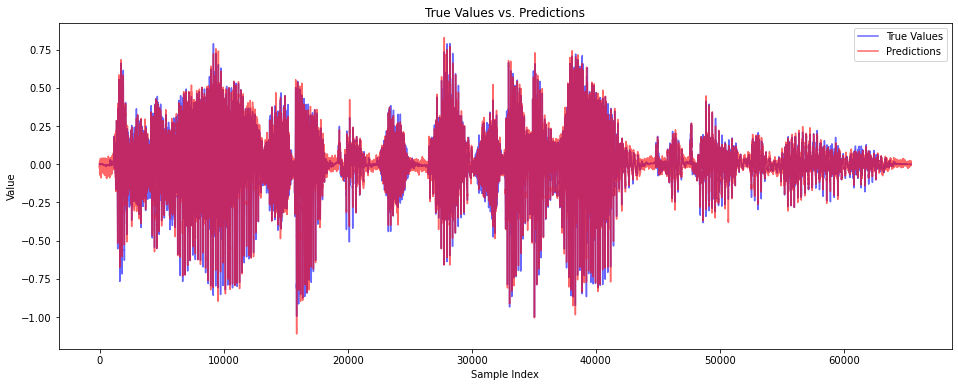

In [294]:
# Convert the predictions and true values to numpy arrays for easier plotting
predictions = np.array(predictions).flatten()  # Flatten in case outputs are multi-dimensional
true_values = np.array(true_values).flatten()

# Plotting the true values vs. predicted values
plt.figure(figsize=(16,6))
plt.plot(true_values, label='True Values', color='blue', alpha=0.6)
plt.plot(predictions, label='Predictions', color='red', alpha=0.6)
plt.legend()
plt.title('True Values vs. Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


In [296]:
import torch
import numpy as np
from scipy.io.wavfile import write

def tensor_to_wav(tensor, filename, sample_rate=44100, max_amp=1):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data*max_amp)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(torch.tensor(predictions), "long.wav", sample_rate=sample_rate,max_amp = max_amp )


Saved as long.wav


In [297]:
from IPython.display import Audio

# Play the .wav file
Audio("long.wav")


In [70]:
Audio("first_try.wav")

Sample Rate: 24000
Data Shape: (14400,)
19288


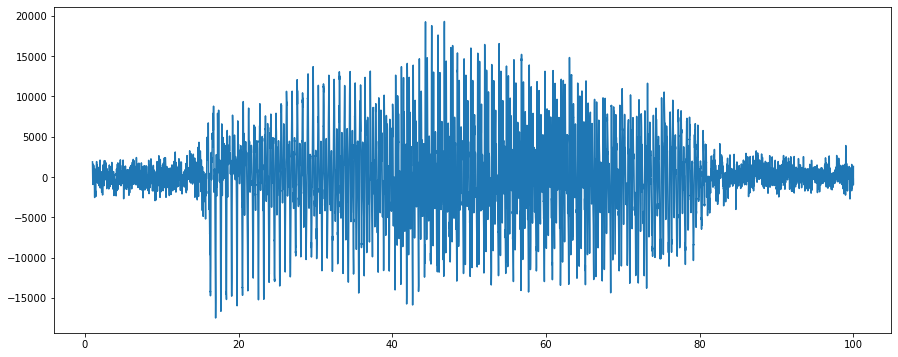

In [276]:
file_path = 'first_try.wav'
sample_rate, data_test = wavfile.read(file_path)

# Print out the sample rate and the shape of the numpy array
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
data_t = torch.from_numpy(np.linspace(1,100,data.shape[0]))

##data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data_test, label='Layer Output')


print(max_amp)


In [295]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
total_params = count_parameters(model)
print(f"Total number of trainable parameters: {total_params}")


Total number of trainable parameters: 104330


In [ ]:
also, this is for sure using less of the t than needed, like, some of the higher bits are always -1.  

In [277]:
torch.save(model.state_dict(), "first_try_model_weights.pth")

In [278]:
torch.save(model, "first_try_model.pth")